### Carla tracks explorative data analysis

Main task of this notebook is to get a sense for the carla data.

In [13]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
os.chdir('../..')
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [7]:
track_files = os.listdir(Path('carla/data') )
dfs = []
for file in track_files:
    dfs.append(pd.read_parquet(Path('carla/data') / file))


In [8]:
tracks_df = pd.concat(dfs)

In [9]:
print(tracks_df.shape)
tracks_df.head(2)


(1549, 15)


,actor_id,actor_type,actor_speed_xyz,actor_acceleration_xyz,actor_location_xyz,actor_bbox,lane_id,road_id,light_state,timestamp,actor_heading_xyz,actor_speed,actor_acceleration,map,scene_id
0,675.0,vehicle.lincoln.mkz_2020,"[0.0, 0.0, -0.22141234576702118]","[0.0, 0.0, -9.799999237060547]","[-3.679999589920044, 288.2200012207031, 0.4968...","[[-2.452479839324951, -0.9183569550514221, 0.0...",-1.0,0.0,0.0,5.621540,"[3.1749393656355096e-06, -1.0, 0.0]",0.000000e+00,0.000000e+00,Carla/Maps/Town02_Opt,3
1,674.0,vehicle.ford.crown,"[-4.643896822642546e-09, -1.1092406104751262e-...","[-8.347845437128854e-08, 7.543522251296508e-09...","[150.24002075195312, 191.77003479003906, 0.252...","[[-2.497429132461548, -0.9003614783287048, -0....",-1.0,6.0,0.0,5.822385,"[1.0, -3.1957933970261365e-06, 0.0]",-4.643861e-09,-8.347848e-08,Carla/Maps/Town02_Opt,3


### High level learnings:

* hm, timestamps are not alligned, getting syncronous mode running would be great...
* road_id and lane_id seem to be ok


In [15]:
tracks_df.timestamp.value_counts()
tracks_df.road_id.value_counts()
tracks_df.actor_id.value_counts()

actor_id
675.0    50
674.0    50
673.0    50
672.0    50
671.0    50
670.0    50
669.0    50
729.0    50
728.0    50
727.0    50
726.0    50
725.0    50
724.0    50
723.0    50
722.0    50
266.0    50
265.0    50
264.0    50
263.0    50
262.0    50
261.0    50
260.0    50
622.0    50
618.0    50
621.0    50
620.0    50
619.0    50
616.0    50
617.0    50
615.0    50
267.0    49
Name: count, dtype: int64

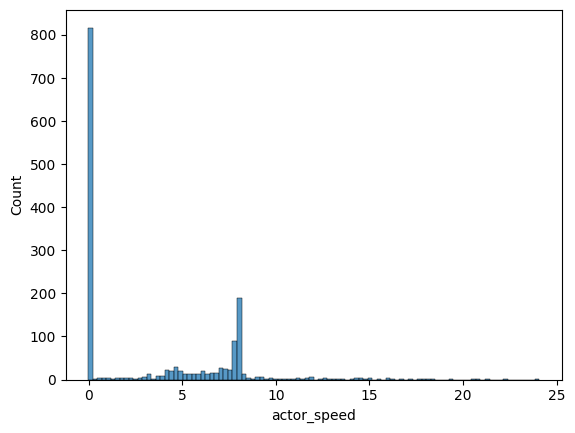

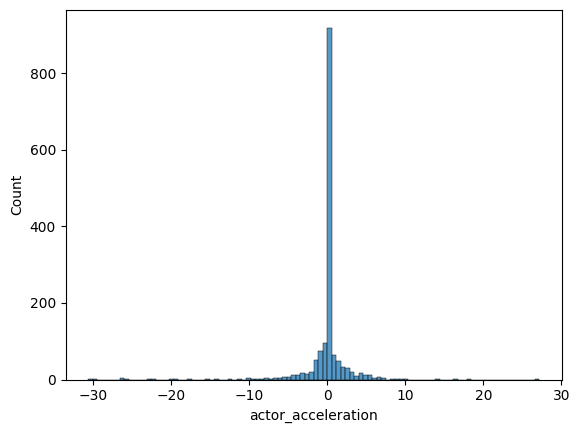

In [16]:
sns.histplot(tracks_df.actor_speed, bins=100)
plt.show()
sns.histplot(tracks_df.actor_acceleration, bins=100)
plt.show()

In [22]:
tracks_df.timestamp.round(1).value_counts()

timestamp
22.2    4
13.8    4
36.9    4
70.9    4
36.3    4
       ..
82.0    1
82.2    1
84.1    1
84.3    1
84.5    1
Name: count, Length: 769, dtype: int64